In [1]:
# organize imports
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import normalize
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
import keras.backend as K
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import random
import pydot
import tensorflow as tf


Using TensorFlow backend.


In [2]:
# seed for reproducing same results
seed = 9
np.random.seed(seed)


# Helper functions below

## Load data and create test and training inputs and outputs

In [3]:
# filenames must be a list
def loadData(filenames, validationRatio = 0.10, testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"]):
    # load simple dataset
    for i, filename in enumerate(filenames):
        PATH_FILE_TRAINING3 = os.getcwd()+"/"+filename
        f = h5py.File(PATH_FILE_TRAINING3, "r")
        # split into input and output variables
        if i==0:
            X       = f[fieldNames[0]].value;     
            X      = X.transpose();
            Y        = f[fieldNames[1]].value;      
            Y       = Y.transpose();
        else:
            X1       = f[fieldNames[0]].value;     
            X1      = X1.transpose();
            Y1        = f[fieldNames[1]].value;      
            Y1       = Y1.transpose();
            X = np.vstack((X,X1))
            Y = np.vstack((Y,Y1))   
    # Take out some data (10%) to save for validation
    (X_rest, X_valid, Y_rest, Y_valid) = train_test_split(X, Y, test_size=validationRatio, random_state=seed)
    # split the remaining data into training (75%) and testing (25%)
    (X_train, X_test, Y_train, Y_test) = train_test_split(X_rest, Y_rest, test_size=testRatio, random_state=seed)

    # Examine shape of data
#     print(np.shape(X))
#     print(np.shape(Y))
#     print(np.shape(X_valid))
#     print(np.shape(Y_valid))
#     print(np.shape(X_train))
#     print(np.shape(X_test))
#     print(np.shape(Y_train))
#     print(np.shape(Y_test))
    return X_train, X_test, X_valid, Y_train, Y_test, Y_valid



In [4]:
def saveSplitDataValidTrainTest(filename, X_train_norm, X_test_norm, X_valid_norm, Y_train_norm, Y_test_norm, Y_valid_norm):
    # Save these into an h5 file
    hf = h5py.File(filename, 'w')
    hf.create_dataset("X_train_norm", data = X_train_norm)
    hf.create_dataset("X_test_norm", data = X_test_norm)
    hf.create_dataset("X_valid_norm", data = X_valid_norm)
    hf.create_dataset("Y_train_norm", data = Y_train_norm)
    hf.create_dataset("Y_test_norm", data = Y_test_norm)
    hf.create_dataset("Y_valid_norm", data = Y_valid_norm)
    hf.close()

In [5]:
def loadSplitDataValidTrainTest(filename):
    hf = h5py.File(filename, "r")
    X_train_norm = np.array(hf.get("X_train_norm"))
    X_test_norm = np.array(hf.get("X_test_norm"))
    X_valid_norm = np.array(hf.get("X_valid_norm"))
    Y_train_norm = np.array(hf.get("Y_train_norm"))
    Y_test_norm = np.array(hf.get("Y_test_norm"))
    Y_valid_norm = np.array(hf.get("Y_valid_norm"))
    hf.close() 
    return X_train_norm, X_test_norm, X_valid_norm, Y_train_norm, Y_test_norm, Y_valid_norm

## Create custom metric to print learning rate after each epoch

In [6]:
class CustomMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_lr = K.eval(self.model.optimizer.lr)
        lrHist.append(current_lr)
        print("Learning rate: ",current_lr)
#     def on_batch_end(self, batch, logs):
#         weights, _biases = model.get_weights()
#         w1, w2 = weights
#         weights = [w1[0], w2[0]]
#         print('on_batch_end() model.weights:', weights)
#         weights_history.append(weights)

In [7]:
def plotCoeffsExpectedAndNN(Y, NN):
    # Y and NN have same shape (1,*) 
    xs = range(1,np.size(Y,0)+1)
    plt.scatter(xs, Y, color='r',marker='s', s = 30)
    plt.scatter(xs, NN, color='g', marker='^', s = 20)
    plt.title('Poly coeffs deviation from expected')
    plt.ylabel('Value of coeff')
    plt.xlabel('Coefficient number')
    plt.legend(['true coeffs', 'NN output coeffs'], loc='lower left')
    plt.show()

In [8]:
## Normalize dataset

In [9]:
def normalize_datasets(X, Y):
    # Normalize all datasets to be between [0,1]
    xMin = np.amin(X, axis=0)
    xMax = np.amax(X, axis=0)
    xRange = xMax - xMin
    xRange[xRange == 0] = 1.0
    xRange[abs(xRange) <1.0e-20]=1.0
    X = (X-xMin)/xRange

    yMin = np.amin(Y, axis=0)
    yMax = np.amax(Y, axis=0)
    yRange = yMax - yMin
    yRange[yRange == 0] = 1.0
    yRange[abs(yRange) <1.0e-20]=1.0
    Y = (Y-yMin)/yRange
    
    return (X, Y, xMin, xRange, yMin, yRange)

In [10]:
def getDataParamsFromHDF5(filename):
    hf = h5py.File(filename, "r")
    xMin_train = np.array(hf.get("xMin_train"))
    yMin_train = np.array(hf.get("yMin_train"))
    xRange_train = np.array(hf.get("xRange_train"))
    yRange_train = np.array(hf.get("yRange_train"))
    xMin_test = np.array(hf.get("xMin_test"))
    yMin_test = np.array(hf.get("yMin_test"))
    xRange_test = np.array(hf.get("xRange_test"))
    yRange_test = np.array(hf.get("yRange_test"))
    xMin_valid = np.array(hf.get("xMin_valid"))
    yMin_valid = np.array(hf.get("yMin_valid"))
    xRange_valid = np.array(hf.get("xRange_valid"))
    yRange_valid = np.array(hf.get("yRange_valid"))
    hf.close() 
    return xMin_train, yMin_train, xRange_train, yRange_train, xMin_test, yMin_test, xRange_test, yRange_test, xMin_valid, yMin_valid, xRange_valid, yRange_valid

In [11]:
def saveDataParamsToHDF5(filename, xMin_train, yMin_train, xRange_train, yRange_train, xMin_test, yMin_test, xRange_test, yRange_test, xMin_valid, yMin_valid, xRange_valid, yRange_valid):
    # Save these params into an h5 file
    hf = h5py.File(filename, 'w')
    hf.create_dataset("xMin_train", data = xMin_train)
    hf.create_dataset("yMin_train", data = yMin_train)
    hf.create_dataset("xRange_train", data = xRange_train)
    hf.create_dataset("yRange_train", data = yRange_train)
    hf.create_dataset("xMin_test", data = xMin_test)
    hf.create_dataset("yMin_test", data = yMin_test)
    hf.create_dataset("xRange_test", data = xRange_test)
    hf.create_dataset("yRange_test", data = yRange_test)
    hf.create_dataset("xMin_valid", data = xMin_valid)
    hf.create_dataset("yMin_valid", data = yMin_valid)
    hf.create_dataset("xRange_valid", data = xRange_valid)
    hf.create_dataset("yRange_valid", data = yRange_valid)
    hf.close()

# Train on the polynomial coeffs for polygonal obstacles for new astrobeeSE3

In [12]:
(X_train, X_test, X_valid, Y_train, Y_test, Y_valid) = loadData(["PolyAstrobeeCoeffs.jld2"], validationRatio = 0.1, testRatio = 0.25, fieldNames = ["train_input_collected", "all_coeffs"])
# Each input is of size 26
# Each output is of size 95
print(np.shape(X_valid))
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(Y_valid))
print(np.shape(Y_train))
print(np.shape(Y_test))

(X_train_norm, Y_train_norm, xMin_train, xRange_train, yMin_train, yRange_train) = normalize_datasets(X_train, Y_train)
(X_test_norm, Y_test_norm, xMin_test, xRange_test, yMin_test, yRange_test) = normalize_datasets(X_test, Y_test)
(X_valid_norm, Y_valid_norm, xMin_valid, xRange_valid, yMin_valid, yRange_valid) = normalize_datasets(X_valid, Y_valid)

filename = "PolyAstrobeeCoeffsNormalized.jld2"
saveSplitDataValidTrainTest(filename, X_train_norm, X_test_norm, X_valid_norm, 
                            Y_train_norm, Y_test_norm, Y_valid_norm)

filename = "PolyAstrobeeParams.h5"
saveDataParamsToHDF5(filename, xMin_train, yMin_train, xRange_train, yRange_train, 
                     xMin_test, yMin_test, xRange_test, yRange_test, 
                     xMin_valid, yMin_valid, xRange_valid, yRange_valid)


(424, 26)
(2862, 26)
(954, 26)
(424, 95)
(2862, 95)
(954, 95)


In [13]:
# create the model
model = Sequential()
model.add(Dense(128, input_dim=26, activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(95, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-50)

lrHist = []

In [14]:
# fit the model
histSimple = model.fit(X_train_norm, Y_train_norm, validation_data=(X_test_norm, Y_test_norm), epochs=50, batch_size=1, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test_norm, Y_test_norm)

Train on 2862 samples, validate on 954 samples
Epoch 1/50
2862/2862 [==============================] - 5s 2ms/step - loss: 0.0735 - mean_squared_error: 0.0735 - val_loss: 0.1059 - val_mean_squared_error: 0.1059
('Learning rate: ', 0.001)
Epoch 2/50
2862/2862 [==============================] - 4s 2ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0964 - val_mean_squared_error: 0.0964
('Learning rate: ', 0.001)
Epoch 3/50
2862/2862 [==============================] - 5s 2ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0967 - val_mean_squared_error: 0.0967
('Learning rate: ', 0.001)
Epoch 4/50
2862/2862 [==============================] - 5s 2ms/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0904 - val_mean_squared_error: 0.0904
('Learning rate: ', 0.001)
Epoch 5/50
2862/2862 [==============================] - 5s 2ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0885 - val_mean_squared_error: 0.0885
('Learning rate: ', 0.001

2862/2862 [==============================] - 4s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0719 - val_mean_squared_error: 0.0719
('Learning rate: ', 1.0000001e-17)
Epoch 43/50
2862/2862 [==============================] - 4s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0719 - val_mean_squared_error: 0.0719
('Learning rate: ', 1.0000001e-17)
Epoch 44/50
2862/2862 [==============================] - 4s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0719 - val_mean_squared_error: 0.0719
('Learning rate: ', 1e-18)
Epoch 45/50
2862/2862 [==============================] - 4s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0719 - val_mean_squared_error: 0.0719
('Learning rate: ', 1e-18)
Epoch 46/50
2862/2862 [==============================] - 4s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0719 - val_mean_squared_error: 0.0719
('Learning rate: ', 1.00000003e-19)
Epoch 47/50
2862/2862 [====

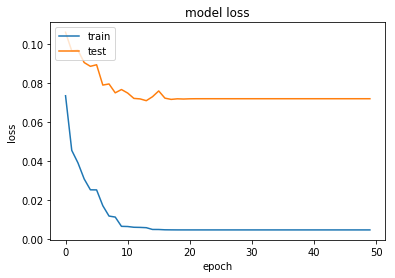

In [15]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

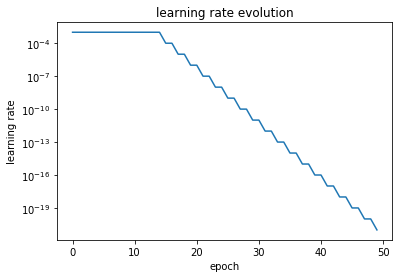

In [16]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [17]:
# save model to hdf5 file
model.save('PolyAstrobee.h5') 

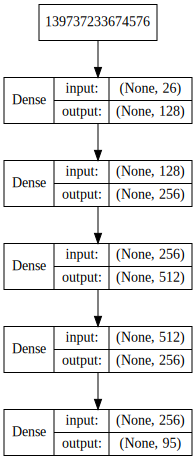

In [18]:
# plot_model(model, to_file='NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = load_model('PolyAstrobee.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [19]:
model = load_model('PolyAstrobee.h5')

# serialize model to JSON
model_json = model.to_json()
with open("PolyAstrobee.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("PolyAstrobeeWeights.h5")
print("Saved model to disk")

file = h5py.File('PolyAstrobeeWeights.h5', 'r')
print(list(file.keys()))
file.close()

Saved model to disk
[u'dense_1', u'dense_2', u'dense_3', u'dense_4', u'dense_5']


# Run model on some inputs and plot results

### Try training data

In [20]:
model = load_model('PolyAstrobee.h5')
# This won't randomize as long as seed doesn't change. 
# (X_train, X_test, Y_train, Y_test) = loadData(["PolyAstrobeeCoeffs.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])

# To be safe, let's do this instead
filename = "PolyAstrobeeCoeffsNormalized.jld2"
(X_train_norm, X_test_norm, X_valid_norm, 
 Y_train_norm, Y_test_norm, Y_valid_norm) = loadSplitDataValidTrainTest(filename)

filename = "PolyAstrobeeParams.h5"
(xMin_train, yMin_train, xRange_train, yRange_train, 
 xMin_test, yMin_test, xRange_test, yRange_test, 
 xMin_valid, yMin_valid, xRange_valid, yRange_valid) = getDataParamsFromHDF5(filename)

In [21]:
Idx = [0,1,2,3,700]
NN_input = np.array(X_train_norm)
NN_output_norm = model.predict(NN_input[Idx])
NN_output = NN_output_norm*yRange_train + yMin_train

Training Examples


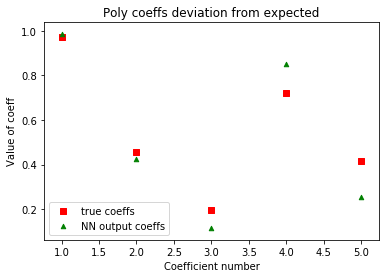

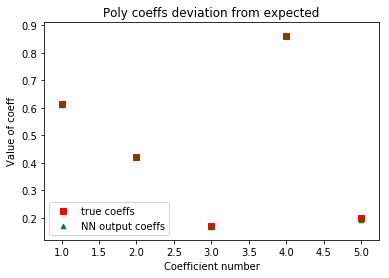

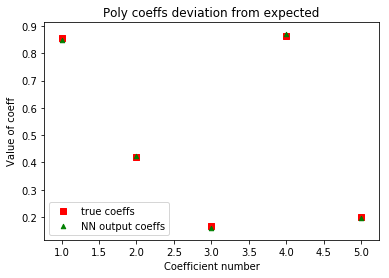

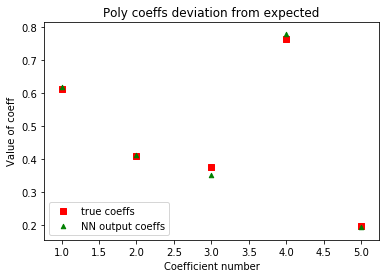

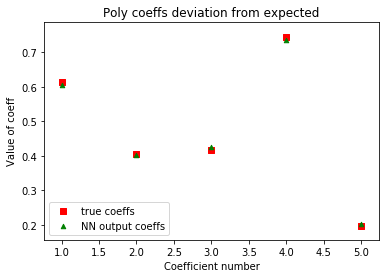

In [22]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    true_X_coeff_norm = Y_train_norm[train_idx,0:5]
    NN_X_coeff_norm = NN_output_norm[NN_idx,0:5]
    plotCoeffsExpectedAndNN(true_X_coeff_norm, NN_X_coeff_norm)
    print("")


### Try test data

In [23]:
Idx = [61,83,100, 123]
NN_input = np.array(X_test_norm)
NN_output_norm = model.predict(NN_input[Idx])
NN_output = NN_output_norm*yRange_test + yMin_test


Test Examples


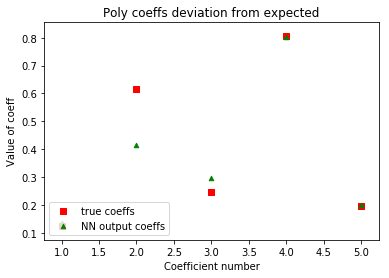

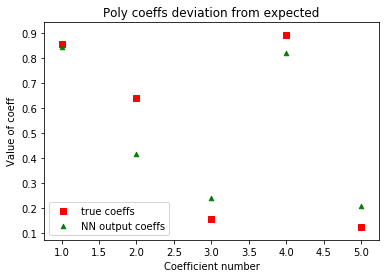

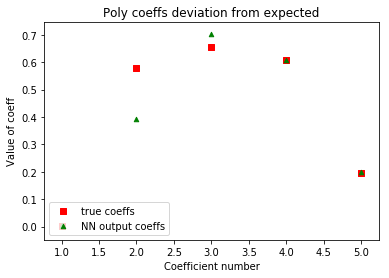

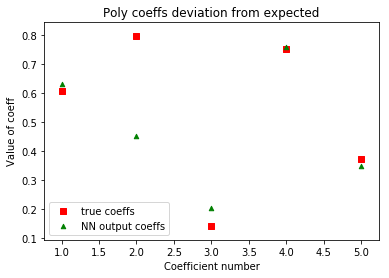

In [24]:
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    true_X_coeff_norm = Y_test_norm[test_idx,0:5]
    NN_X_coeff_norm = NN_output_norm[NN_idx,0:5]
    plotCoeffsExpectedAndNN(true_X_coeff_norm, NN_X_coeff_norm)
    print("")


### Try validation data

In [25]:
Idx = [61,83,100, 101]
NN_input = np.array(X_valid_norm)
NN_output_norm = model.predict(NN_input[Idx])
NN_output = NN_output_norm*yRange_valid + yMin_valid


Validation Examples


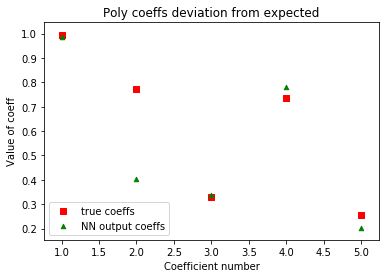

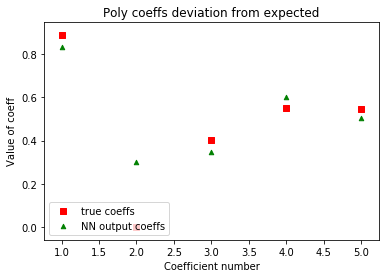

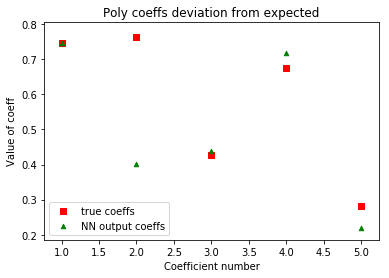

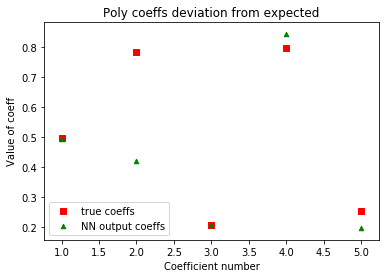

In [26]:
print("Validation Examples")
for NN_idx, valid_idx in enumerate(Idx):
    true_X_coeff_norm = Y_valid_norm[valid_idx,0:5]
    NN_X_coeff_norm = NN_output_norm[NN_idx,0:5]
    plotCoeffsExpectedAndNN(true_X_coeff_norm, NN_X_coeff_norm)
    print("")
